# Hebb則の拡張と主成分分析
## 主成分分析 (Principal component analysis; PCA)

主成分分析の解説書く．SVDでの実装．

In [1]:
using PyPlot, Random, Distributions, LinearAlgebra
rc("axes.spines", top=false, right=false)

In [2]:
d = MvNormal([0,0], [1.0 0.5; 0.5 1.0]) # multivariate normal distribution
N = 300 # sample size
Random.seed!(0) # set seed
X = rand(d, N)  # generate toy data

2×300 Matrix{Float64}:
 0.942971  1.52507   -1.20577   …  -1.33405    -0.0682456  1.10984
 0.587466  0.869836  -0.332845     -0.0347524   0.0516093  0.574491

In [6]:
U, S, V = svd(X*X')

SVD{Float64, Float64, Matrix{Float64}}
U factor:
2×2 Matrix{Float64}:
 -0.722509  -0.691362
 -0.691362   0.722509
singular values:
2-element Vector{Float64}:
 418.9073852600819
 138.22321877667497
Vt factor:
2×2 Matrix{Float64}:
 -0.722509  -0.691362
 -0.691362   0.722509

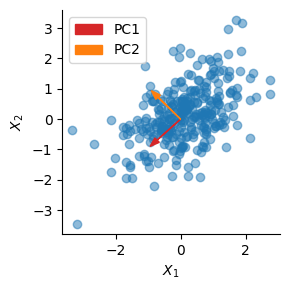

In [7]:
figure(figsize=(3,3))
scatter(X[1,:], X[2,:], alpha=0.5)
arrow(0, 0, V[1,1], V[2,1], head_width=0.2, label="PC1", color="tab:red")
arrow(0, 0, V[1,2], V[2,2], head_width=0.2, label="PC2", color="tab:orange")
xlabel(L"$X_1$"); ylabel(L"$X_2$")
legend(); tight_layout()

## Oja則
単一の出力を持つ線形ニューロンを仮定する．

$$
y = \mathbf{w}^\top \mathbf{x}=\mathbf{x}^\top \mathbf{w}
$$

ここで$\mathbf{x}\in \mathbb{R}^d, \mathbf{w}\in \mathbb{R}^d, y\in \mathbb{R}$である．$\eta$を学習率とすると，

$$
\mathbf{w}\leftarrow\frac{\mathbf{w}+\eta \mathbf{x}y}{\|\mathbf{w}+\eta \mathbf{x}y\|}
$$

とすれば正規化できる．ここで，$f(\eta):=\dfrac{\mathbf{w}+\eta \mathbf{x}y}{\|\mathbf{w}+\eta \mathbf{x}y\|}$とし，$\eta=0$においてTaylor展開を行うと，

$$
\begin{aligned}
f(\eta)&\approx f(0) + \eta \left.\frac{df(\eta^*)}{d\eta^*}\right|_{\eta^*=0} + \mathcal{O}(\eta^2)\\
&=\frac{\mathbf{w}}{\|\mathbf{w}\|} + \eta \left(\frac{\mathbf{x}y}{\|\mathbf{w}\|}-\frac{y^2\mathbf{w}}{\|\mathbf{w}\|^3}\right)+ \mathcal{O}(\eta^2)\\
\end{aligned}
$$

ここで$\|\mathbf{w}\|=1$とすれば，

$$
\mathbf{w}\leftarrow \mathbf{w} + \eta \left(\mathbf{x}y-y^2 \mathbf{w}\right)
$$

となる．これを**Oja則 (Oja's rule)** と呼ぶ {cite:p}`ojahoge`．

重みの変化量を$\Delta \mathbf{w}$とし，その期待値を取る．

$$
\begin{aligned}
\Delta \mathbf{w} &= \eta \left(\mathbf{x}y - y^2 \mathbf{w}\right)\\
&=\eta \left(\mathbf{x}\mathbf{x}^\top \mathbf{w} - \left[\mathbf{w}^\top \mathbf{x}\mathbf{x}^\top \mathbf{w}\right] \mathbf{w}\right)\\
\mathbb{E}\left[\Delta \mathbf{w}\right] &= \eta \left(\mathbf{C} \mathbf{w} - \left[\mathbf{w}^\top \mathbf{C} \mathbf{w}\right] \mathbf{w}\right)\\
\end{aligned}
$$

$\mathbf{C}:=\mathbb{E}[\mathbf{x}\mathbf{x}^\top]\in \mathbb{R}^{d\times d}$とする．$\mathbf{x}$の平均が0の場合，$\mathbf{C}$は分散共分散行列である．$\mathbb{E}\left[\Delta \mathbf{w}\right]=0$となる$\mathbf{w}$が収束する固定点(fixed point)では次の式が成り立つ．

$$
\mathbf{C}\mathbf{w} = \lambda \mathbf{w}
$$

これは固有値問題であり，$\lambda:=\mathbf{w}^\top \mathbf{C} \mathbf{w}$は固有値，$\mathbf{w}$は固有ベクトル(eigen vector)になる．

ここでサンプルサイズを$n$とし，$\mathbf{X} \in \mathbb{R}^{d\times n}, \mathbf{y}=\mathbf{X}^\top\mathbf{w} \in \mathbb{R}^n$とする．標本平均で近似して$\mathbf{C}\simeq \mathbf{X}\mathbf{X}^\top$とする．この場合，

$$
\begin{aligned}
\mathbb{E}\left[\Delta \mathbf{w}\right] &\simeq \eta \left(\mathbf{X}\mathbf{X}^\top \mathbf{w} - \left[\mathbf{w}^\top \mathbf{X}\mathbf{X}^\top \mathbf{w}\right] \mathbf{w}\right)\\
&=\eta \left(\mathbf{X}\mathbf{y} - \left[\mathbf{y}^\top\mathbf{y}\right] \mathbf{w}\right)
\end{aligned}
$$

となる．

In [4]:
w = randn(2) # initialize weight
w ./= sqrt.(sum(w.^2, dims=1)) # L2 normalize
initw = copy(w) # save initial weight
η = 1e-3 # learning rate
for _ in 1:200
    y = X' * w  
    w += η * (X * y - y' * y * w) # Oja's rule
end

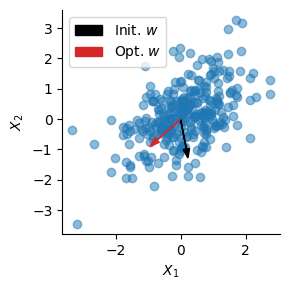

In [5]:
figure(figsize=(3,3))
scatter(X[1,:], X[2,:], alpha=0.5)
arrow(0,0,initw[1],initw[2], head_width=0.2, color="k", label=L"Init. $w$")
arrow(0,0,w[1],w[2], head_width=0.2, color="tab:red", label=L"Opt. $w$")
xlabel(L"$X_1$"); ylabel(L"$X_2$")
tight_layout()
legend(); tight_layout()

$q$個の複数出力を持つ場合を考えよう．重み行列を$\mathbf{W} \in \mathbb{R}^{q\times d}$, 出力を$\mathbf{Y}=\mathbf{W}\mathbf{X} \in \mathbb{R}^{q\times n}$とする．この場合の更新則は

$$
\mathbb{E}\left[\Delta \mathbf{W}\right] \simeq \eta \left(\mathbf{Y}\mathbf{X}^\top - \mathrm{Diag}\left[\mathbf{Y}\mathbf{Y}^\top\right] \mathbf{W}\right)
$$

となる．ただし，$\mathrm{Diag}(\cdot)$は行列の対角成分からなる対角行列を生み出す作用素である．


In [19]:
W = randn(2, 2) # initialize weight
W ./= sqrt.(sum(W.^2, dims=1)) # normalize
initW = copy(W) # save initial weight
for _ in 1:200
    Y = W * X
    W += η * (Y * X' - Diagonal(Y * Y') * W) # Oja's rule
end

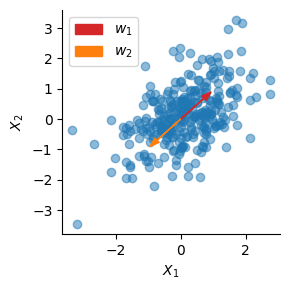

In [21]:
figure(figsize=(3,3))
scatter(X[1,:], X[2,:], alpha=0.5)
arrow(0, 0, W[1,1], W[1,2], head_width=0.2, label=L"$w_1$", color="tab:red")
arrow(0, 0, W[2,1], W[2,2], head_width=0.2, label=L"$w_2$", color="tab:orange")
xlabel(L"$X_1$"); ylabel(L"$X_2$")
legend(); tight_layout()

PCAのように直交はしない．工夫が必要となる．

## Sanger則
**Sanger則 (Sanger's rule)**，あるいは**一般化Hebb則 (generalized Hebbian algorithm; GHA)** は，Oja則を複数の出力を持つニューロンに拡張したものである．Oja則ではPCAの第1主成分しか求めることができなかったが，Sanger則を用いれば第2主成分以降も求めることができる．PCAでは各主成分ベクトルは直交するという拘束条件があるが，Gram–Schmidtの正規直交化法を学習則に取り入れることでPCAを実現している．

Sanger則は

$$
\mathbb{E}\left[\Delta \mathbf{W}\right] \simeq \eta \left(\mathbf{Y}\mathbf{X}^\top - \mathrm{LT}\left[\mathbf{Y}\mathbf{Y}^\top\right] \mathbf{W}\right)
$$

$\mathrm{LT}(\cdot)$は行列の対角成分を含めた上側の要素を0にした下三角行列(lower triangular matrix)を作り出す作用素である．

In [23]:
W = randn(2, 2) # initialize weight
W ./= sqrt.(sum(W.^2, dims=1)) # normalize
initW = copy(W) # save initial weight
for _ in 1:200
    Y = W * X
    W += η * (Y * X' - LowerTriangular(Y * Y') * W) # Sanger's rule
end

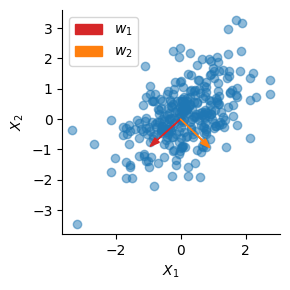

In [24]:
figure(figsize=(3,3))
scatter(X[1,:], X[2,:], alpha=0.5)
arrow(0, 0, W[1,1], W[1,2], head_width=0.2, label=L"$w_1$", color="tab:red")
arrow(0, 0, W[2,1], W[2,2], head_width=0.2, label=L"$w_2$", color="tab:orange")
xlabel(L"$X_1$"); ylabel(L"$X_2$")
legend(); tight_layout()

## 参考文献
```{bibliography}
:filter: docname in docnames
```